In [14]:
import math
import numpy as np
import pandas as pd

import yfinance as yf

import datetime as dt
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [15]:
# Crude Oil, RBOB Gasoline, Heating Oil
cl_f = "CL=F"
rb_f = "RB=F"
ho_f = "HO=F"

# Refiner symbol
refiner = "PSX"

# Zscore rolling window
window = 22

In [16]:
# start_date = "2015-01-01"
# end_date = dt.datetime.now().strftime("%Y-%m-%d")

# # Download historical data from yf API
# data = yf.download([cl_f, rb_f, ho_f, refiner], start=start_date, end=end_date, group_by='ticker')

# # download data to csv
# data.to_csv(f"Crack_Spread_vs_Refiner_data.csv")
     
# Load the CSV with MultiIndex columns (Tickers, OHLCV)
df = pd.read_csv(f"Crack_Spread_vs_Refiner_data.csv", header=[0,1], index_col=0)

# Drop any rows that are completely NaN (e.g. 'Date' row)
df = df.dropna(how='all')

# Convert all values to float
df = df.astype(float)

# datetime index
df.index = pd.to_datetime(df.index)

# Show the result
df.head()

Ticker           CL=F                                               RB=F  \
Price            Open       High        Low      Close    Volume    Open   
Date                                                                       
2015-01-02  53.759998  55.110001  52.029999  52.689999  268708.0  1.4806   
2015-01-05  52.610001  52.730000  49.680000  50.040001  375782.0  1.4403   
2015-01-06  50.000000  50.369999  47.549999  47.930000  451642.0  1.3750   
2015-01-07  48.000000  49.310001  46.830002  48.650002  460083.0  1.3451   
2015-01-08  48.779999  49.650002  47.730000  48.790001  362081.0  1.3346   

Ticker                                         HO=F                          \
Price         High     Low   Close   Volume    Open    High     Low   Close   
Date                                                                          
2015-01-02  1.5072  1.4287  1.4334  42774.0  1.8533  1.8774  1.7871  1.7957   
2015-01-05  1.4404  1.3615  1.3814  46187.0  1.7955  1.7996  1.7386  1.7492   
2015-01-06  1.3989  1.3437  1.3543  61161.0  1.7500  1.7629  1.7025  1.7262   
2015-01-07  1.3675  1.3110  1.3376  56396.0  1.7020  1.7256  1.6715  1.6999   
2015-01-08  1.3529  1.3127  1.3409  62629.0  1.6970  1.7195  1.6766  1.7110   

Ticker                     PSX                                              
Price        Volume       Open       High        Low      Close     Volume  
Date                                                                        
2015-01-02  46068.0  48.274282  48.840547  47.829355  48.732689  2545200.0  
2015-01-05  66059.0  48.024870  48.260814  45.260947  45.786766  5886000.0  
2015-01-06  73014.0  45.611499  46.353038  44.505924  44.505924  5793500.0  
2015-01-07  75085.0  45.011510  45.766535  44.425022  44.701412  5556700.0  
2015-01-08  67237.0  45.233995  46.447428  44.896931  46.440685  5432700.0

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2699 entries, 2015-01-02 to 2025-09-22
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (CL=F, Open)    2696 non-null   float64
 1   (CL=F, High)    2696 non-null   float64
 2   (CL=F, Low)     2696 non-null   float64
 3   (CL=F, Close)   2696 non-null   float64
 4   (CL=F, Volume)  2696 non-null   float64
 5   (RB=F, Open)    2697 non-null   float64
 6   (RB=F, High)    2697 non-null   float64
 7   (RB=F, Low)     2697 non-null   float64
 8   (RB=F, Close)   2697 non-null   float64
 9   (RB=F, Volume)  2697 non-null   float64
 10  (HO=F, Open)    2697 non-null   float64
 11  (HO=F, High)    2697 non-null   float64
 12  (HO=F, Low)     2697 non-null   float64
 13  (HO=F, Close)   2697 non-null   float64
 14  (HO=F, Volume)  2697 non-null   float64
 15  (PSX, Open)     2696 non-null   float64
 16  (PSX, High)     2696 non-null   float64
 17  (PSX, Low)     

In [18]:
data = df.copy()

# Use only the 'Close' prices from level 1 of the multiindex columns
data = data.xs("Close", level=1, axis=1)

data.head()

Ticker,CL=F,RB=F,HO=F,PSX
Date,,,,
2015-01-02,52.689999,1.4334,1.7957,48.732689
2015-01-05,50.040001,1.3814,1.7492,45.786766
2015-01-06,47.930000,1.3543,1.7262,44.505924
2015-01-07,48.650002,1.3376,1.6999,44.701412
2015-01-08,48.790001,1.3409,1.7110,46.440685


In [19]:
# Construct the crack spread which is the difference between the price of crude oil (x3), minus gasoline contract (x2) and heating oil contract (x1)
data["crack"] = data[cl_f] * 3 - data[rb_f] * 2 - data[ho_f]

# Create a series with the spread between the crack spread and the refiner stock
data["spread"] = data["crack"] - data[refiner]

# Compute the returns of each position
data['returns'] = data['spread'].pct_change()

data.head()

Ticker,CL=F,RB=F,HO=F,PSX,crack,spread,returns
Date,,,,,,,
2015-01-02,52.689999,1.4334,1.7957,48.732689,153.407496,104.674807,NaN
2015-01-05,50.040001,1.3814,1.7492,45.786766,145.608003,99.821237,-0.046368
2015-01-06,47.930000,1.3543,1.7262,44.505924,139.355201,94.849277,-0.049809
2015-01-07,48.650002,1.3376,1.6999,44.701412,141.574905,96.873492,0.021341
2015-01-08,48.790001,1.3409,1.7110,46.440685,141.977203,95.536518,-0.013801


In [20]:
# Compute the rolling zsore of the spread between the crack spread and the refiner stock
data['zscore'] = (data['spread'] - data['spread'].rolling(window).mean()) / data['spread'].rolling(window).std()

# Create a position indicatior to get short signals
data['position'] = np.select(
    [
        data['zscore'] < -1.5,
        data['zscore'] > 1.5
    ],
    [
        1,
        -1
    ],
    default=0
)

data.head()

Ticker,CL=F,RB=F,HO=F,PSX,crack,spread,returns,zscore,position
Date,,,,,,,,,
2015-01-02,52.689999,1.4334,1.7957,48.732689,153.407496,104.674807,NaN,NaN,0
2015-01-05,50.040001,1.3814,1.7492,45.786766,145.608003,99.821237,-0.046368,NaN,0
2015-01-06,47.930000,1.3543,1.7262,44.505924,139.355201,94.849277,-0.049809,NaN,0
2015-01-07,48.650002,1.3376,1.6999,44.701412,141.574905,96.873492,0.021341,NaN,0
2015-01-08,48.790001,1.3409,1.7110,46.440685,141.977203,95.536518,-0.013801,NaN,0


In [21]:
# Compute the returns of the strategy
strategy_returns = data['returns'] * data['position'].shift(1)

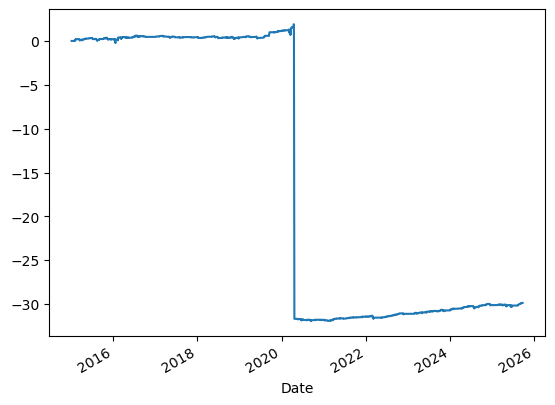

In [22]:
# Plot the strategy returns
strategy_returns.cumsum().plot()
plt.show()

In [23]:
# Calculate cumulative return
cumulative_returns = strategy_returns.cumsum().iloc[-1]

# Calculate the Sharpe ratio
sharpe = strategy_returns.mean() / strategy_returns.std()

# Calculate the maximum drawdown
max_drawdown = strategy_returns.cumsum().cummax() - strategy_returns.cumsum()
max_drawdown = max_drawdown.max()

# Print the results
print(f"Sharpe: {sharpe}")
print(f"Cumulative Returns: {cumulative_returns}")
print(f"Max Drawdown: {max_drawdown}")

Sharpe: -0.017566853544898103
Cumulative Returns: -29.849645280333526
Max Drawdown: 33.8075789581339


In [ ]:
# Load the CSV with MultiIndex columns (Tickers, OHLCV)
df = pd.read_csv(f"Crack_Spread_vs_Refiner_data.csv", header=[0,1], index_col=0)

# Drop any rows that are completely NaN (e.g. 'Date' row)
df = df.dropna(how='all')

# Convert all values to float
df = df.astype(float)

# datetime index
df.index = pd.to_datetime(df.index)

data = df.copy()

# Use only the 'Close' prices from level 1 of the multiindex columns
data = data.xs("Close", level=1, axis=1)

# Construct the crack spread which is the difference between the price of crude oil (x3), minus gasoline contract (x2) and heating oil contract (x1)
data["crack"] = data[cl_f] * 3 - data[rb_f] * 2 - data[ho_f]

# Create a series with the spread between the crack spread and the refiner stock
data["spread"] = data["crack"] - data[refiner]

# Compute the returns of each position
data['returns'] = data['spread'].pct_change()

# Compute the rolling zsore of the spread between the crack spread and the refiner stock
data['zscore'] = (data['spread'] - data['spread'].rolling(window).mean()) / data['spread'].rolling(window).std()

# Create a position indicatior to get short signals
data['position'] = np.select(
    [
        data['zscore'] < -1.5,
        data['zscore'] > 1.5
    ],
    [
        1,
        -1
    ],
    default=0
)

# Compute the returns of the strategy
strategy_returns = data['returns'] * data['position'].shift(1)

# Plot the strategy returns
strategy_returns.cumsum().plot()
plt.show()

In [ ]:
# Calculate cumulative return
cumulative_returns = strategy_returns.cumsum().iloc[-1]

# Calculate the Sharpe ratio
sharpe = strategy_returns.mean() / strategy_returns.std()

# Calculate the maximum drawdown
max_drawdown = strategy_returns.cumsum().cummax() - strategy_returns.cumsum()
max_drawdown = max_drawdown.max()

# Print the results
print(f"Sharpe: {sharpe}")
print(f"Cumulative Returns: {cumulative_returns}")
print(f"Max Drawdown: {max_drawdown}")